In [1]:
# ============================================================
# Model Evaluation & Analysis (Setup & Imports)
# ------------------------------------------------------------
# Prepare environment, libraries, and device for model
# evaluation: metrics, confusion matrices, visual analysis,
# and exporting results.
# ============================================================

# -------------------------
# Standard libs: I/O, data, plotting, and progress bars
# -------------------------
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')  # suppress noisy warnings in notebooks

# -------------------------
# PyTorch (model inference utilities)
# -------------------------
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# -------------------------
# Computer vision & augmentations
# -------------------------
import cv2                   # image I/O & resizing
import albumentations as A   # preprocessing pipelines (if needed)
from albumentations.pytorch import ToTensorV2

# -------------------------
# Segmentation Models (for model architecture / loading)
# -------------------------
import segmentation_models_pytorch as smp

# -------------------------
# Scikit-learn: metrics & reporting
# -------------------------
from sklearn.metrics import confusion_matrix, classification_report

# -------------------------
# Quick environment summary (useful for reproducibility & debugging)
# -------------------------
print("=" * 60)
print("EVALUATION SETUP")
print("=" * 60)
print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

# Select device (GPU preferred)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print("=" * 60)


EVALUATION SETUP
PyTorch: 2.6.0+cu124
CUDA Available: True
Device: cuda


In [2]:
# ============================================================
# 2. Configuration — Evaluation
# ------------------------------------------------------------
# Central configuration for model evaluation: dataset paths,
# checkpoint location, output folders, and class metadata.
# ============================================================

import os  # required for platform checks (NUM_WORKERS)

class Config:
    """Evaluation configuration (update BASE_DIR if needed)."""
    BASE_DIR = Path(r"D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation")
    
    # -------------------------
    # Data paths (test & val)
    # -------------------------
    DATA_DIR    = BASE_DIR / "data" / "raw" / "FloodNet"
    TEST_IMAGES = DATA_DIR / "test" / "test-org-img"
    TEST_MASKS  = DATA_DIR / "test" / "test-label-img"
    VAL_IMAGES  = DATA_DIR / "val" / "val-org-img"
    VAL_MASKS   = DATA_DIR / "val" / "val-label-img"
    
    # -------------------------
    # Model checkpoint to load
    # -------------------------
    CHECKPOINT_PATH = BASE_DIR / "models" / "checkpoints" / "unet_resnet34_best.pth"
    
    # -------------------------
    # Output directories for evaluation artifacts
    # -------------------------
    RESULTS_DIR = BASE_DIR / "results"
    EVAL_DIR    = RESULTS_DIR / "evaluation"
    METRICS_DIR = RESULTS_DIR / "metrics"
    VIZ_DIR     = RESULTS_DIR / "visualizations" / "evaluation"
    
    # -------------------------
    # Model / runtime params
    # -------------------------
    ENCODER_NAME = "resnet34"            # encoder backbone (for reference)
    NUM_CLASSES  = 10                    # number of segmentation classes
    IMG_SIZE     = (256, 256)            # (H, W) used at inference
    BATCH_SIZE   = 8
    NUM_WORKERS  = 0 if os.name == 'nt' else 4  # Windows-safe default
    
    # -------------------------
    # Class labels & visualization colors
    # -------------------------
    CLASS_NAMES = [
        "Background", "Building-flooded", "Building-non-flooded",
        "Road-flooded", "Road-non-flooded", "Water",
        "Tree", "Vehicle", "Pool", "Grass"
    ]
    
    # RGB colors (0-255) used for mask visualization
    CLASS_COLORS = {
        0: (0, 0, 0),       1: (255, 0, 0),     2: (0, 0, 255),
        3: (255, 165, 0),   4: (128, 128, 128), 5: (0, 255, 255),
        6: (0, 255, 0),     7: (255, 0, 255),   8: (255, 255, 255),
        9: (0, 128, 0)
    }

# Ensure evaluation output folders exist
Config.EVAL_DIR.mkdir(parents=True, exist_ok=True)
Config.VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Print a concise configuration summary for logs
print("\n" + "=" * 60)
print("CONFIGURATION")
print("=" * 60)
print(f"📂 Base Directory: {Config.BASE_DIR}")
print(f"🔍 Checkpoint:     {Config.CHECKPOINT_PATH.name}")
print(f"📊 Output folder:  {Config.EVAL_DIR}")
print("=" * 60)



CONFIGURATION
📂 Base Directory: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation
🔍 Checkpoint:     unet_resnet34_best.pth
📊 Output folder:  D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\evaluation


In [3]:
# ============================================================
# 3. Dataset and DataLoader — Evaluation
# ------------------------------------------------------------
# PyTorch Dataset for the TEST set. Returns (image_tensor, mask_tensor, filename).
# Includes robust mask lookup for FloodNet naming variants and minimal test transforms.
# ============================================================

from torch.utils.data import Dataset

class FloodNetDataset(Dataset):
    """
    FloodNet Dataset for evaluation/inference.
    Returns:
      image (Tensor) : normalized image tensor (C, H, W)
      mask  (Tensor) : ground-truth mask (H, W) as LongTensor
      name  (str)    : original image filename (useful for saving predictions)
    """
    def __init__(self, image_dir, mask_dir, transform=None, img_size=(256, 256)):
        self.image_dir = Path(image_dir)
        self.mask_dir  = Path(mask_dir)
        self.transform = transform
        self.img_size  = img_size

        # Collect common image file types and sort for deterministic ordering
        self.images = sorted([
            f for f in self.image_dir.glob("*")
            if f.suffix.lower() in [".jpg", ".jpeg", ".png"]
        ])
        print(f"📂 Loaded {len(self.images)} images from {image_dir.name}")

    def __len__(self):
        """Return dataset size (number of images)."""
        return len(self.images)

    def _find_mask_path(self, image_path):
        """
        Heuristic mask finder to handle FloodNet naming conventions:
          - stem.png
          - stem_lab.png
          - stem_mask.png
        Fallback: first mask file containing the image stem.
        Returns Path or None.
        """
        img_stem = image_path.stem
        for pattern in [f"{img_stem}.png", f"{img_stem}_lab.png", f"{img_stem}_mask.png"]:
            mask_path = self.mask_dir / pattern
            if mask_path.exists():
                return mask_path

        # Fallback search (may return the first match)
        for mask_file in self.mask_dir.glob(f"*{img_stem}*"):
            return mask_file

        return None

    def __getitem__(self, idx):
        """
        Load image + mask, resize, apply transforms (normalize + ToTensorV2 by default),
        and return (image_tensor, mask_tensor, filename).
        """
        img_path = self.images[idx]

        # ---- Load image (BGR -> RGB) ----
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # ---- Load mask (single-channel) or fallback to zeros ----
        mask_path = self._find_mask_path(img_path)
        if mask_path:
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        else:
            mask = np.zeros(image.shape[:2], dtype=np.uint8)

        # ---- Resize to inference size ----
        image = cv2.resize(image, self.img_size, interpolation=cv2.INTER_LINEAR)
        mask  = cv2.resize(mask,  self.img_size, interpolation=cv2.INTER_NEAREST)

        # ---- Apply transform (normalize + to-tensor) or convert manually ----
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        else:
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
            mask  = torch.from_numpy(mask).long()

        # ---- Ensure mask is LongTensor (required for metrics/loss) ----
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask)
        mask = mask.long()

        # Return filename for mapping predictions to original names
        return image, mask, str(img_path.name)


def get_test_transform(img_size=(256, 256)):
    """
    Minimal preprocessing for test-time inference:
      - ImageNet normalization
      - Convert to PyTorch tensor (ToTensorV2 keeps dtype & channel order)
    """
    return A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])


# -------------------------
# Create test dataset & loader (deterministic ordering, no shuffling)
# -------------------------
print("\n" + "=" * 60)
print("LOADING TEST DATASET")
print("=" * 60)

test_dataset = FloodNetDataset(
    Config.TEST_IMAGES, Config.TEST_MASKS,
    transform=get_test_transform(Config.IMG_SIZE),
    img_size=Config.IMG_SIZE
)

test_loader = DataLoader(
    test_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,                 # keep order for mapping filenames → predictions
    num_workers=Config.NUM_WORKERS,
    pin_memory=True
)

print(f"\n✅ Test set loaded: {len(test_dataset)} images ({len(test_loader)} batches)")



LOADING TEST DATASET
📂 Loaded 448 images from test-org-img

✅ Test set loaded: 448 images (56 batches)


In [4]:
# ============================================================
# 4. Load Model
# ------------------------------------------------------------
# Build U-Net architecture (no pretrained encoder weights) and
# load the trained checkpoint from disk. Move model to device
# and set to eval() for inference.
# ============================================================

print("\n" + "=" * 60)
print("LOADING MODEL")
print("=" * 60)

# Instantiate model architecture (encoder weights None — we'll load our checkpoint)
model = smp.Unet(
    encoder_name=Config.ENCODER_NAME,  # backbone used during training
    encoder_weights=None,              # do not load imagenet here; we load checkpoint weights below
    in_channels=3,
    classes=Config.NUM_CLASSES,
    activation=None                    # return raw logits for evaluation
)

# -------------------------
# Load checkpoint (robust handling)
# -------------------------
# Two safe-loading attempts are provided:
#  - Preferred: attempt a "restricted" load if environment supports it
#  - Fallback: plain torch.load using map_location (works for your own checkpoints)
import numpy as np
from numpy.core.multiarray import scalar

try:
    # Optional: try a safer loader path (may require specific PyTorch versions)
    torch.serialization.add_safe_globals([scalar])   # best-effort — no harm if it fails
    checkpoint = torch.load(Config.CHECKPOINT_PATH, map_location=device)
    print("Loaded checkpoint (attempted secure load).")
except Exception:
    # Fallback: standard load (safe for checkpoints produced by you)
    checkpoint = torch.load(Config.CHECKPOINT_PATH, map_location=device, weights_only=False)
    print("Loaded checkpoint using fallback loader.")

# Restore model weights and prepare for inference
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()   # set eval mode (disable dropout, use running stats in BN)

# -------------------------
# Log checkpoint info
# -------------------------
print(f"\n✅ Model loaded successfully!")
print(f"   Checkpoint:     {Config.CHECKPOINT_PATH.name}")
# Some checkpoints may not include these keys — guard printing
epoch_info = checkpoint.get('epoch', 'N/A')
val_iou_info = checkpoint.get('val_iou', None)
val_loss_info = checkpoint.get('val_loss', None)

print(f"   Trained Epoch:  {epoch_info}")
if val_iou_info is not None:
    print(f"   Val IoU:        {val_iou_info:.4f}")
if val_loss_info is not None:
    print(f"   Val Loss:       {val_loss_info:.4f}")
print("=" * 60)



LOADING MODEL
Loaded checkpoint using fallback loader.

✅ Model loaded successfully!
   Checkpoint:     unet_resnet34_best.pth
   Trained Epoch:  38
   Val IoU:        0.6671
   Val Loss:       0.4377


In [5]:
# ============================================================
# SegmentationMetrics — comprehensive per-class & global metrics
# ------------------------------------------------------------
# Tracks predictions/targets, maintains a confusion matrix
# (rows = ground-truth, columns = predictions) and computes:
#  - IoU, Dice, Precision, Recall, F1 (per-class)
#  - Pixel accuracy, mean IoU/Dice (optionally ignoring background)
# ============================================================

class SegmentationMetrics:
    """Calculate comprehensive segmentation metrics for multi-class masks."""

    def __init__(self, num_classes, class_names):
        """
        Args:
            num_classes (int): number of classes (including background).
            class_names (list[str]): list of class names (len == num_classes).
        """
        self.num_classes = int(num_classes)
        self.class_names = list(class_names)
        self.reset()

    def reset(self):
        """Reset all accumulated statistics."""
        # confusion_matrix[true, pred]
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes), dtype=np.int64)
        self.all_preds = []    # flattened predictions (for later analysis/reporting)
        self.all_targets = []  # flattened targets

    def update(self, pred, target):
        """
        Update confusion matrix with a single prediction/target pair.
        Accepts either numpy arrays or PyTorch tensors.

        Args:
            pred (np.ndarray|torch.Tensor): predicted class ids (H,W) or (N,H,W)
            target (np.ndarray|torch.Tensor): true class ids (H,W) or (N,H,W)
        """
        # Convert tensors to numpy
        if isinstance(pred, torch.Tensor):
            pred = pred.cpu().numpy()
        if isinstance(target, torch.Tensor):
            target = target.cpu().numpy()

        # Flatten to 1D arrays for bincount accounting
        pred_flat = pred.flatten()
        target_flat = target.flatten()

        # Store raw lists (useful for classification_report / further analysis)
        self.all_preds.extend(pred_flat.tolist())
        self.all_targets.extend(target_flat.tolist())

        # Only consider valid target labels (0 .. num_classes-1)
        mask = (target_flat >= 0) & (target_flat < self.num_classes)
        valid_pred = pred_flat[mask]
        valid_target = target_flat[mask]

        # Map (target, pred) pairs to linear indices and count occurrences
        # index = target * num_classes + pred
        indices = self.num_classes * valid_target + valid_pred
        cm_update = np.bincount(indices, minlength=self.num_classes**2)
        self.confusion_matrix += cm_update.reshape(self.num_classes, self.num_classes)

    # -------------------------
    # Per-class metrics
    # -------------------------
    def get_iou_per_class(self):
        """Intersection over Union for each class. NaN where union==0."""
        intersection = np.diag(self.confusion_matrix).astype(float)
        # union = actual (row sums) + predicted (col sums) - intersection
        union = (self.confusion_matrix.sum(axis=1) + self.confusion_matrix.sum(axis=0) - intersection)
        iou = np.where(union > 0, intersection / union, np.nan)
        return iou

    def get_dice_per_class(self):
        """Dice coefficient for each class. NaN where denominator==0."""
        intersection = np.diag(self.confusion_matrix).astype(float)
        sum_pred = self.confusion_matrix.sum(axis=0).astype(float)   # predicted positives per class (col sums)
        sum_target = self.confusion_matrix.sum(axis=1).astype(float) # actual positives per class (row sums)
        denominator = sum_pred + sum_target
        dice = np.where(denominator > 0, 2.0 * intersection / denominator, np.nan)
        return dice

    def get_precision_per_class(self):
        """
        Precision per class = TP / (predicted positives).
        predicted positives = column sums (model predicted that class).
        """
        true_positive = np.diag(self.confusion_matrix).astype(float)
        predicted_positive = self.confusion_matrix.sum(axis=0).astype(float)  # column sums
        precision = np.where(predicted_positive > 0, true_positive / predicted_positive, np.nan)
        return precision

    def get_recall_per_class(self):
        """
        Recall per class = TP / (actual positives).
        actual positives = row sums (ground truth count per class).
        """
        true_positive = np.diag(self.confusion_matrix).astype(float)
        actual_positive = self.confusion_matrix.sum(axis=1).astype(float)  # row sums
        recall = np.where(actual_positive > 0, true_positive / actual_positive, np.nan)
        return recall

    def get_f1_per_class(self):
        """F1 score per class computed from precision & recall."""
        precision = self.get_precision_per_class()
        recall = self.get_recall_per_class()
        f1 = np.where((precision + recall) > 0, 2.0 * (precision * recall) / (precision + recall), np.nan)
        return f1

    # -------------------------
    # Global metrics
    # -------------------------
    def get_pixel_accuracy(self):
        """Overall pixel accuracy = correct_pixels / total_pixels."""
        correct = np.diag(self.confusion_matrix).sum().astype(float)
        total = self.confusion_matrix.sum().astype(float)
        return (correct / total) if total > 0 else 0.0

    def get_mean_iou(self, ignore_background=False):
        """Mean IoU across classes; optionally ignore background (class 0)."""
        iou = self.get_iou_per_class()
        start_idx = 1 if ignore_background else 0
        valid_iou = iou[start_idx:]
        return np.nanmean(valid_iou)

    def get_mean_dice(self, ignore_background=False):
        """Mean Dice across classes; optionally ignore background (class 0)."""
        dice = self.get_dice_per_class()
        start_idx = 1 if ignore_background else 0
        valid_dice = dice[start_idx:]
        return np.nanmean(valid_dice)

    # -------------------------
    # Summary & reporting
    # -------------------------
    def get_summary(self):
        """
        Return a dictionary containing global metrics and per-class metrics.
        NaN values are converted to 0.0 for easier JSON serialization / reporting.
        """
        iou = self.get_iou_per_class()
        dice = self.get_dice_per_class()
        precision = self.get_precision_per_class()
        recall = self.get_recall_per_class()
        f1 = self.get_f1_per_class()

        per_class = {}
        for i in range(self.num_classes):
            per_class[self.class_names[i]] = {
                'iou': float(iou[i]) if not np.isnan(iou[i]) else 0.0,
                'dice': float(dice[i]) if not np.isnan(dice[i]) else 0.0,
                'precision': float(precision[i]) if not np.isnan(precision[i]) else 0.0,
                'recall': float(recall[i]) if not np.isnan(recall[i]) else 0.0,
                'f1': float(f1[i]) if not np.isnan(f1[i]) else 0.0
            }

        return {
            'pixel_accuracy': float(self.get_pixel_accuracy()),
            'mean_iou': float(self.get_mean_iou(ignore_background=False)),
            'mean_iou_no_bg': float(self.get_mean_iou(ignore_background=True)),
            'mean_dice': float(self.get_mean_dice(ignore_background=False)),
            'mean_dice_no_bg': float(self.get_mean_dice(ignore_background=True)),
            'per_class': per_class
        }

    # -------------------------
    # Utility exports (optional helpers)
    # -------------------------
    def confusion_matrix_df(self):
        """Return confusion matrix as a pandas DataFrame (rows=true, cols=pred)."""
        return pd.DataFrame(
            self.confusion_matrix,
            index=[f"gt_{n}" for n in self.class_names],
            columns=[f"pred_{n}" for n in self.class_names]
        )

    def classification_report(self):
        """
        Return a sklearn-style classification report (precision/recall/f1)
        computed from flattened predictions/targets (useful for quick text reports).
        """
        # If no data collected yet, return empty report
        if len(self.all_targets) == 0:
            return {}
        return classification_report(self.all_targets, self.all_preds, labels=list(range(self.num_classes)),
                                     target_names=self.class_names, output_dict=True)


print("✅ Metrics class defined")


✅ Metrics class defined


In [6]:
# ============================================================
# 6. Run Evaluation
# ------------------------------------------------------------
# Run inference on the TEST set, accumulate predictions and
# compute comprehensive per-class & global metrics.
# ============================================================

print("\n" + "=" * 60)
print("🔍 EVALUATING ON TEST SET")
print("=" * 60)

# Initialize metrics accumulator
metrics = SegmentationMetrics(Config.NUM_CLASSES, Config.CLASS_NAMES)

# Buffers to keep examples for later visualization / analysis
all_images = []  # list of image tensors (CPU, still normalized)
all_masks  = []  # list of ground-truth masks (CPU)
all_preds  = []  # list of predicted masks (CPU)
all_names  = []  # list of original filenames

# Disable gradient computation for inference
with torch.no_grad():
    # Iterate batches from test loader
    for images, masks, names in tqdm(test_loader, desc="Evaluating"):
        # Move images to device for model inference
        images = images.to(device)

        # Forward pass -> logits -> predicted class ids
        outputs = model(images)                 # (B, C, H, W)
        preds   = outputs.argmax(dim=1)         # (B, H, W) - class ids

        # Update metrics (SegmentationMetrics accepts tensors or numpy arrays)
        metrics.update(preds, masks)

        # Save CPU copies for visualization / export
        all_images.extend(images.cpu())         # keep normalized tensors (denormalize later for plotting)
        all_masks.extend(masks.cpu())
        all_preds.extend(preds.cpu())
        all_names.extend(names)

print(f"\n✅ Evaluation complete on {len(test_dataset)} images")

# Produce aggregated summary dictionary
summary = metrics.get_summary()

# Print concise overall metrics to the console
print("\n" + "=" * 60)
print("📊 OVERALL METRICS")
print("=" * 60)
print(f"Pixel Accuracy:        {summary['pixel_accuracy']:.4f}")
print(f"Mean IoU (all):        {summary['mean_iou']:.4f}")
print(f"Mean IoU (no BG):      {summary['mean_iou_no_bg']:.4f}")
print(f"Mean Dice (all):       {summary['mean_dice']:.4f}")
print(f"Mean Dice (no BG):     {summary['mean_dice_no_bg']:.4f}")



🔍 EVALUATING ON TEST SET


Evaluating: 100%|██████████| 56/56 [01:15<00:00,  1.34s/it]


✅ Evaluation complete on 448 images

📊 OVERALL METRICS
Pixel Accuracy:        0.8931
Mean IoU (all):        0.6686
Mean IoU (no BG):      0.7070
Mean Dice (all):       0.7898
Mean Dice (no BG):     0.8233


In [7]:
# ============================================================
# 7. Per-Class Performance
# ------------------------------------------------------------
# Summarize per-class metrics (IoU, Dice, Precision, Recall, F1)
# into a tidy DataFrame and persist to CSV for reporting.
# ============================================================

print("\n" + "=" * 60)
print("📈 PER-CLASS PERFORMANCE")
print("=" * 60)

# Build a list of per-class metric rows for DataFrame creation
per_class_data = []
for class_name, metrics_dict in summary['per_class'].items():
    per_class_data.append({
        'Class': class_name,
        'IoU': metrics_dict['iou'],
        'Dice': metrics_dict['dice'],
        'Precision': metrics_dict['precision'],
        'Recall': metrics_dict['recall'],
        'F1': metrics_dict['f1']
    })

# Create a neat DataFrame for console display and downstream use
df_per_class = pd.DataFrame(per_class_data)
print("\n" + df_per_class.to_string(index=False))

# Persist per-class metrics to CSV for analysis / reporting
csv_path = Config.METRICS_DIR / "test_set_per_class_metrics.csv"
csv_path.parent.mkdir(parents=True, exist_ok=True)  # ensure directory exists
df_per_class.to_csv(csv_path, index=False)
print(f"\n💾 Saved to: {csv_path}")



📈 PER-CLASS PERFORMANCE

               Class      IoU     Dice  Precision   Recall       F1
          Background 0.323101 0.488400   0.523500 0.457711 0.488400
    Building-flooded 0.685910 0.813697   0.754148 0.883458 0.813697
Building-non-flooded 0.750905 0.857734   0.833027 0.883950 0.857734
        Road-flooded 0.607556 0.755875   0.645208 0.912365 0.755875
    Road-non-flooded 0.804076 0.891399   0.908159 0.875247 0.891399
               Water 0.726006 0.841255   0.865543 0.818294 0.841255
                Tree 0.810539 0.895357   0.881201 0.909975 0.895357
             Vehicle 0.508117 0.673843   0.611035 0.751042 0.673843
                Pool 0.601028 0.750803   0.711583 0.794598 0.750803
               Grass 0.868513 0.929630   0.937916 0.921489 0.929630

💾 Saved to: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\metrics\test_set_per_class_metrics.csv


💾 Saved to: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\evaluation\per_class_metrics.png


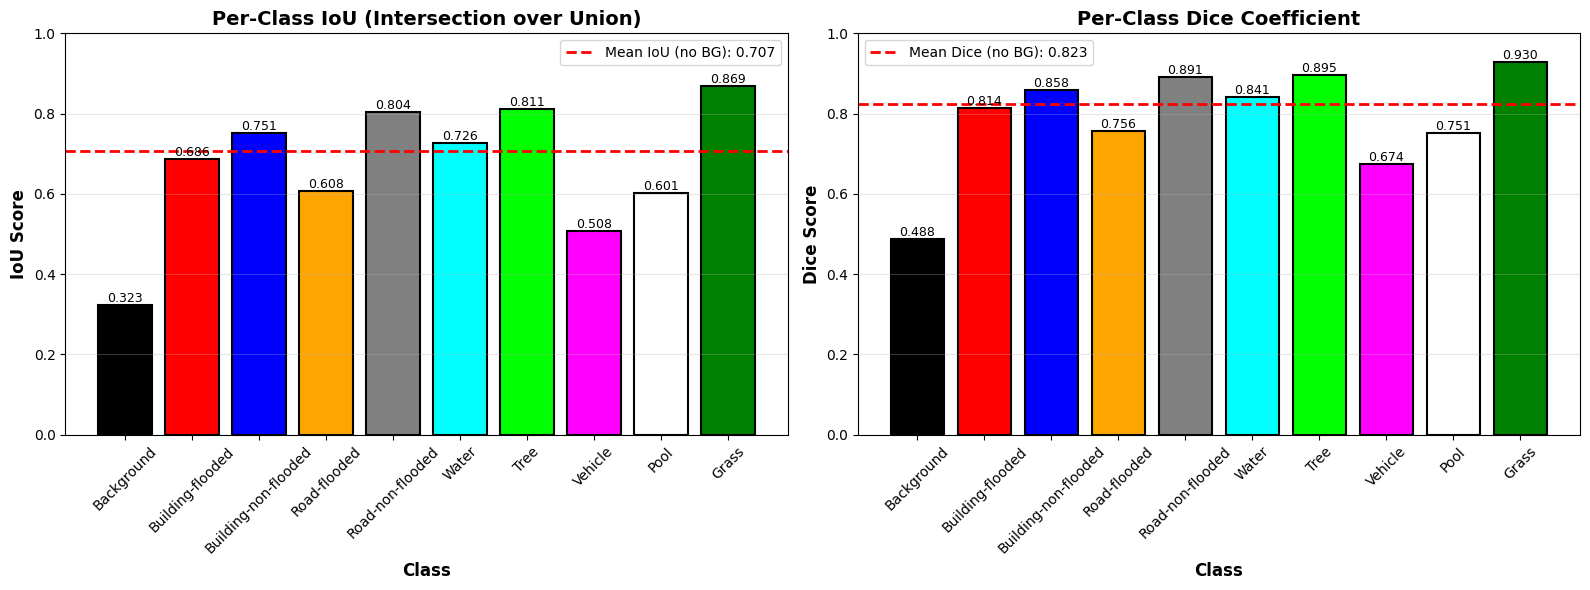

In [8]:
# ============================================================
# 8. Visualize Per-Class Metrics
# ------------------------------------------------------------
# Plot per-class IoU and Dice scores side-by-side and save figure.
# Uses dataset colors for consistency and draws mean (no-background)
# reference lines to highlight overall performance.
# ============================================================

def plot_per_class_metrics(df, save_path=None):
    """Plot per-class IoU and Dice scores."""
    
    # Create two side-by-side panels
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Normalize RGB colors to [0,1] for matplotlib
    colors = [np.array(Config.CLASS_COLORS[i]) / 255.0 for i in range(Config.NUM_CLASSES)]
    
    # -------------------------
    # Left: IoU bar chart
    # -------------------------
    bars1 = axes[0].bar(
        df['Class'], df['IoU'],
        color=colors, edgecolor='black', linewidth=1.5
    )
    axes[0].set_xlabel('Class', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('IoU Score', fontsize=12, fontweight='bold')
    axes[0].set_title('Per-Class IoU (Intersection over Union)', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45, labelsize=10)
    axes[0].set_ylim([0, 1])
    axes[0].grid(axis='y', alpha=0.3)
    
    # Draw mean IoU (excluding background) as reference
    axes[0].axhline(
        y=summary['mean_iou_no_bg'],
        color='red', linestyle='--', linewidth=2,
        label=f"Mean IoU (no BG): {summary['mean_iou_no_bg']:.3f}"
    )
    axes[0].legend()
    
    # Add numeric labels above bars
    for bar in bars1:
        height = bar.get_height()
        axes[0].text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=9
        )
    
    # -------------------------
    # Right: Dice bar chart
    # -------------------------
    bars2 = axes[1].bar(
        df['Class'], df['Dice'],
        color=colors, edgecolor='black', linewidth=1.5
    )
    axes[1].set_xlabel('Class', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Dice Score', fontsize=12, fontweight='bold')
    axes[1].set_title('Per-Class Dice Coefficient', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45, labelsize=10)
    axes[1].set_ylim([0, 1])
    axes[1].grid(axis='y', alpha=0.3)
    
    # Draw mean Dice (excluding background) as reference
    axes[1].axhline(
        y=summary['mean_dice_no_bg'],
        color='red', linestyle='--', linewidth=2,
        label=f"Mean Dice (no BG): {summary['mean_dice_no_bg']:.3f}"
    )
    axes[1].legend()
    
    # Add numeric labels above bars
    for bar in bars2:
        height = bar.get_height()
        axes[1].text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=9
        )
    
    # Layout, save, and display
    plt.tight_layout()
    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"💾 Saved to: {save_path}")
    plt.show()


# Generate and save per-class metric plot
plot_per_class_metrics(
    df_per_class,
    save_path=Config.VIZ_DIR / "per_class_metrics.png"
)



🔍 CONFUSION MATRIX
💾 Saved to: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\evaluation\confusion_matrix.png


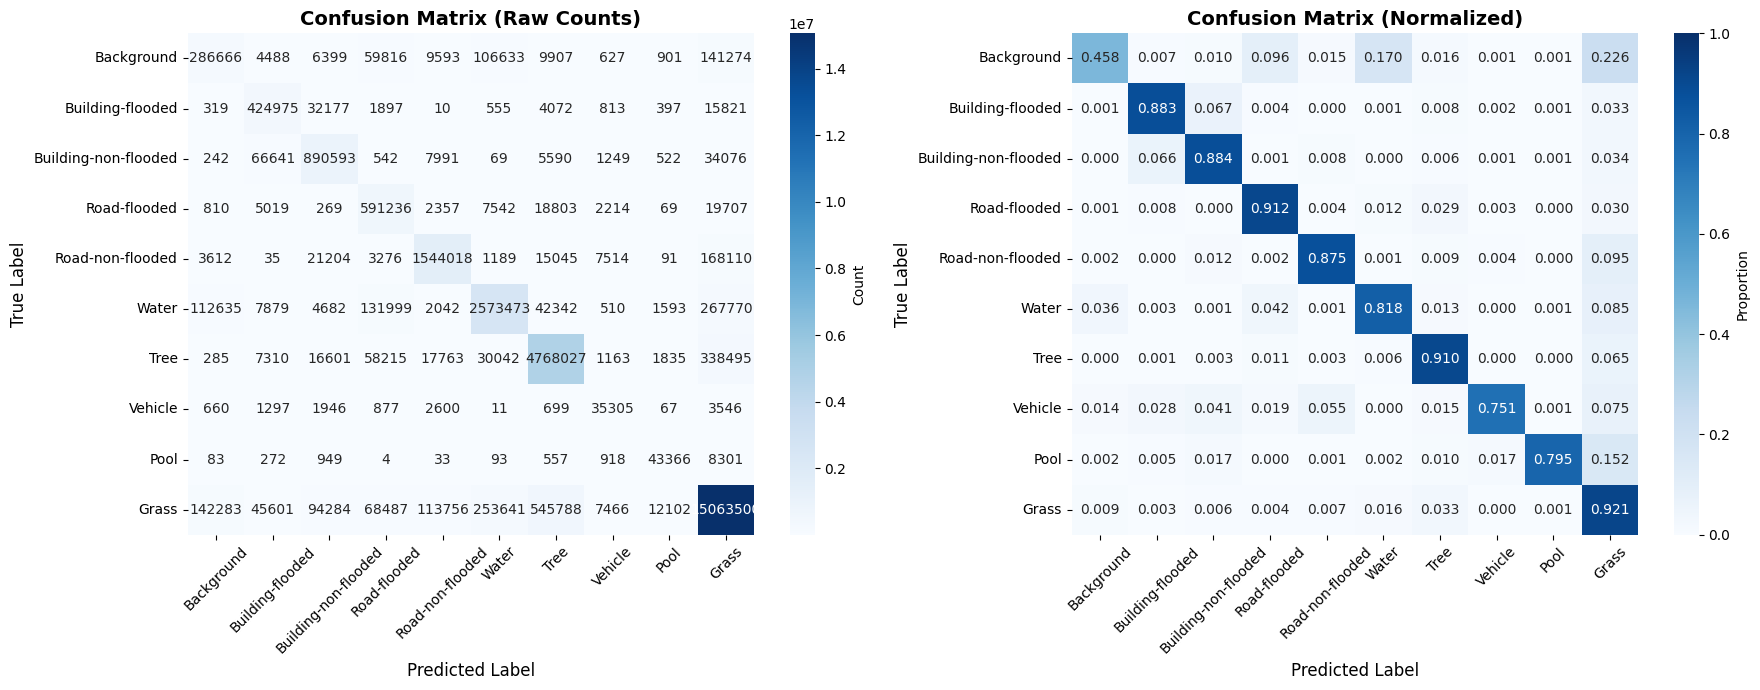

In [9]:
# ============================================================
# 9. Confusion Matrix
# ------------------------------------------------------------
# Compute and plot raw + normalized confusion matrices to
# visualize class-wise errors and common misclassifications.
# ============================================================

def plot_confusion_matrix(cm, class_names, save_path=None):
    """
    Plot raw and normalized confusion matrices side-by-side.

    Args:
        cm (np.ndarray): confusion matrix (shape: num_classes x num_classes)
        class_names (list[str]): ordered class labels for ticks
        save_path (Path|str|None): optional path to save the figure
    """
    # Normalize per-row (true label) to show proportions
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # replace NaN (zero-row) with 0.0

    # Create two panels: left = raw counts, right = normalized proportions
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Panel 1: Raw counts (easy to inspect absolute mistakes)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes[0],
        cbar_kws={'label': 'Count'}
    )
    axes[0].set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].tick_params(axis='y', rotation=0)

    # Panel 2: Row-normalized matrix (proportion of true-class pixels predicted per class)
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.3f',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes[1],
        vmin=0,
        vmax=1,
        cbar_kws={'label': 'Proportion'}
    )
    axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='y', rotation=0)

    plt.tight_layout()

    # Optionally save the visualization
    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"💾 Saved to: {save_path}")

    plt.show()


# -------------------------
# Display confusion matrix for test set
# -------------------------
print("\n" + "=" * 60)
print("🔍 CONFUSION MATRIX")
print("=" * 60)

plot_confusion_matrix(
    metrics.confusion_matrix,
    Config.CLASS_NAMES,
    save_path=Config.VIZ_DIR / "confusion_matrix.png"
)


In [10]:
# ============================================================
# 10. Best and Worst Predictions
# ------------------------------------------------------------
# Compute per-sample IoU (ignoring background), then list the
# top-K best and worst examples for manual inspection.
# ============================================================

def calculate_sample_iou(pred, target, num_classes=10):
    """
    IoU for a single sample (averaged over classes).
    - pred, target: 2D arrays (H, W) of integer class ids.
    - Ignores background class (0) by default for a more
      meaningful per-sample score on foreground classes.
    """
    ious = []
    for cls in range(1, num_classes):  # skip background class (0)
        pred_mask = (pred == cls)
        target_mask = (target == cls)

        intersection = (pred_mask & target_mask).sum()
        union = (pred_mask | target_mask).sum()

        if union > 0:
            ious.append(intersection / union)

    return float(np.mean(ious)) if len(ious) > 0 else 0.0


# --- Compute IoU for every test sample ---
sample_ious = []
for pred_tensor, mask_tensor in zip(all_preds, all_masks):
    # Ensure numpy arrays for the IoU function
    pred_np = pred_tensor.numpy() if isinstance(pred_tensor, np.ndarray) == False else pred_tensor
    mask_np = mask_tensor.numpy() if isinstance(mask_tensor, np.ndarray) == False else mask_tensor

    iou = calculate_sample_iou(pred_np, mask_np, num_classes=Config.NUM_CLASSES)
    sample_ious.append(iou)

sample_ious = np.array(sample_ious)

# --- Select top-K best and worst samples ---
K = 6  # number of examples to show
sorted_indices = np.argsort(sample_ious)

best_indices = sorted_indices[-K:][::-1]   # top-K (descending)
worst_indices = sorted_indices[:K]         # bottom-K (ascending)

# --- Print results (concise, human-readable) ---
print("\n" + "=" * 60)
print("🎯 BEST PREDICTIONS (Top {})".format(K))
print("=" * 60)
for rank, idx in enumerate(best_indices, 1):
    name = all_names[idx]
    print(f"  {rank:2d}. {name:30s}  IoU = {sample_ious[idx]:.4f}")

print("\n" + "=" * 60)
print("⚠️  WORST PREDICTIONS (Bottom {})".format(K))
print("=" * 60)
for rank, idx in enumerate(worst_indices, 1):
    name = all_names[idx]
    print(f"  {rank:2d}. {name:30s}  IoU = {sample_ious[idx]:.4f}")



🎯 BEST PREDICTIONS (Top 6)
   1. 8797.jpg                        IoU = 1.0000
   2. 8201.jpg                        IoU = 1.0000
   3. 8031.jpg                        IoU = 1.0000
   4. 8028.jpg                        IoU = 1.0000
   5. 8027.jpg                        IoU = 1.0000
   6. 8026.jpg                        IoU = 1.0000

⚠️  WORST PREDICTIONS (Bottom 6)
   1. 7743.jpg                        IoU = 0.0019
   2. 7740.jpg                        IoU = 0.1410
   3. 7927.jpg                        IoU = 0.1663
   4. 7930.jpg                        IoU = 0.2265
   5. 10164.jpg                       IoU = 0.2389
   6. 10163.jpg                       IoU = 0.2396



🎨 VISUALIZING BEST PREDICTIONS
💾 Saved to: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\evaluation\best_predictions.png


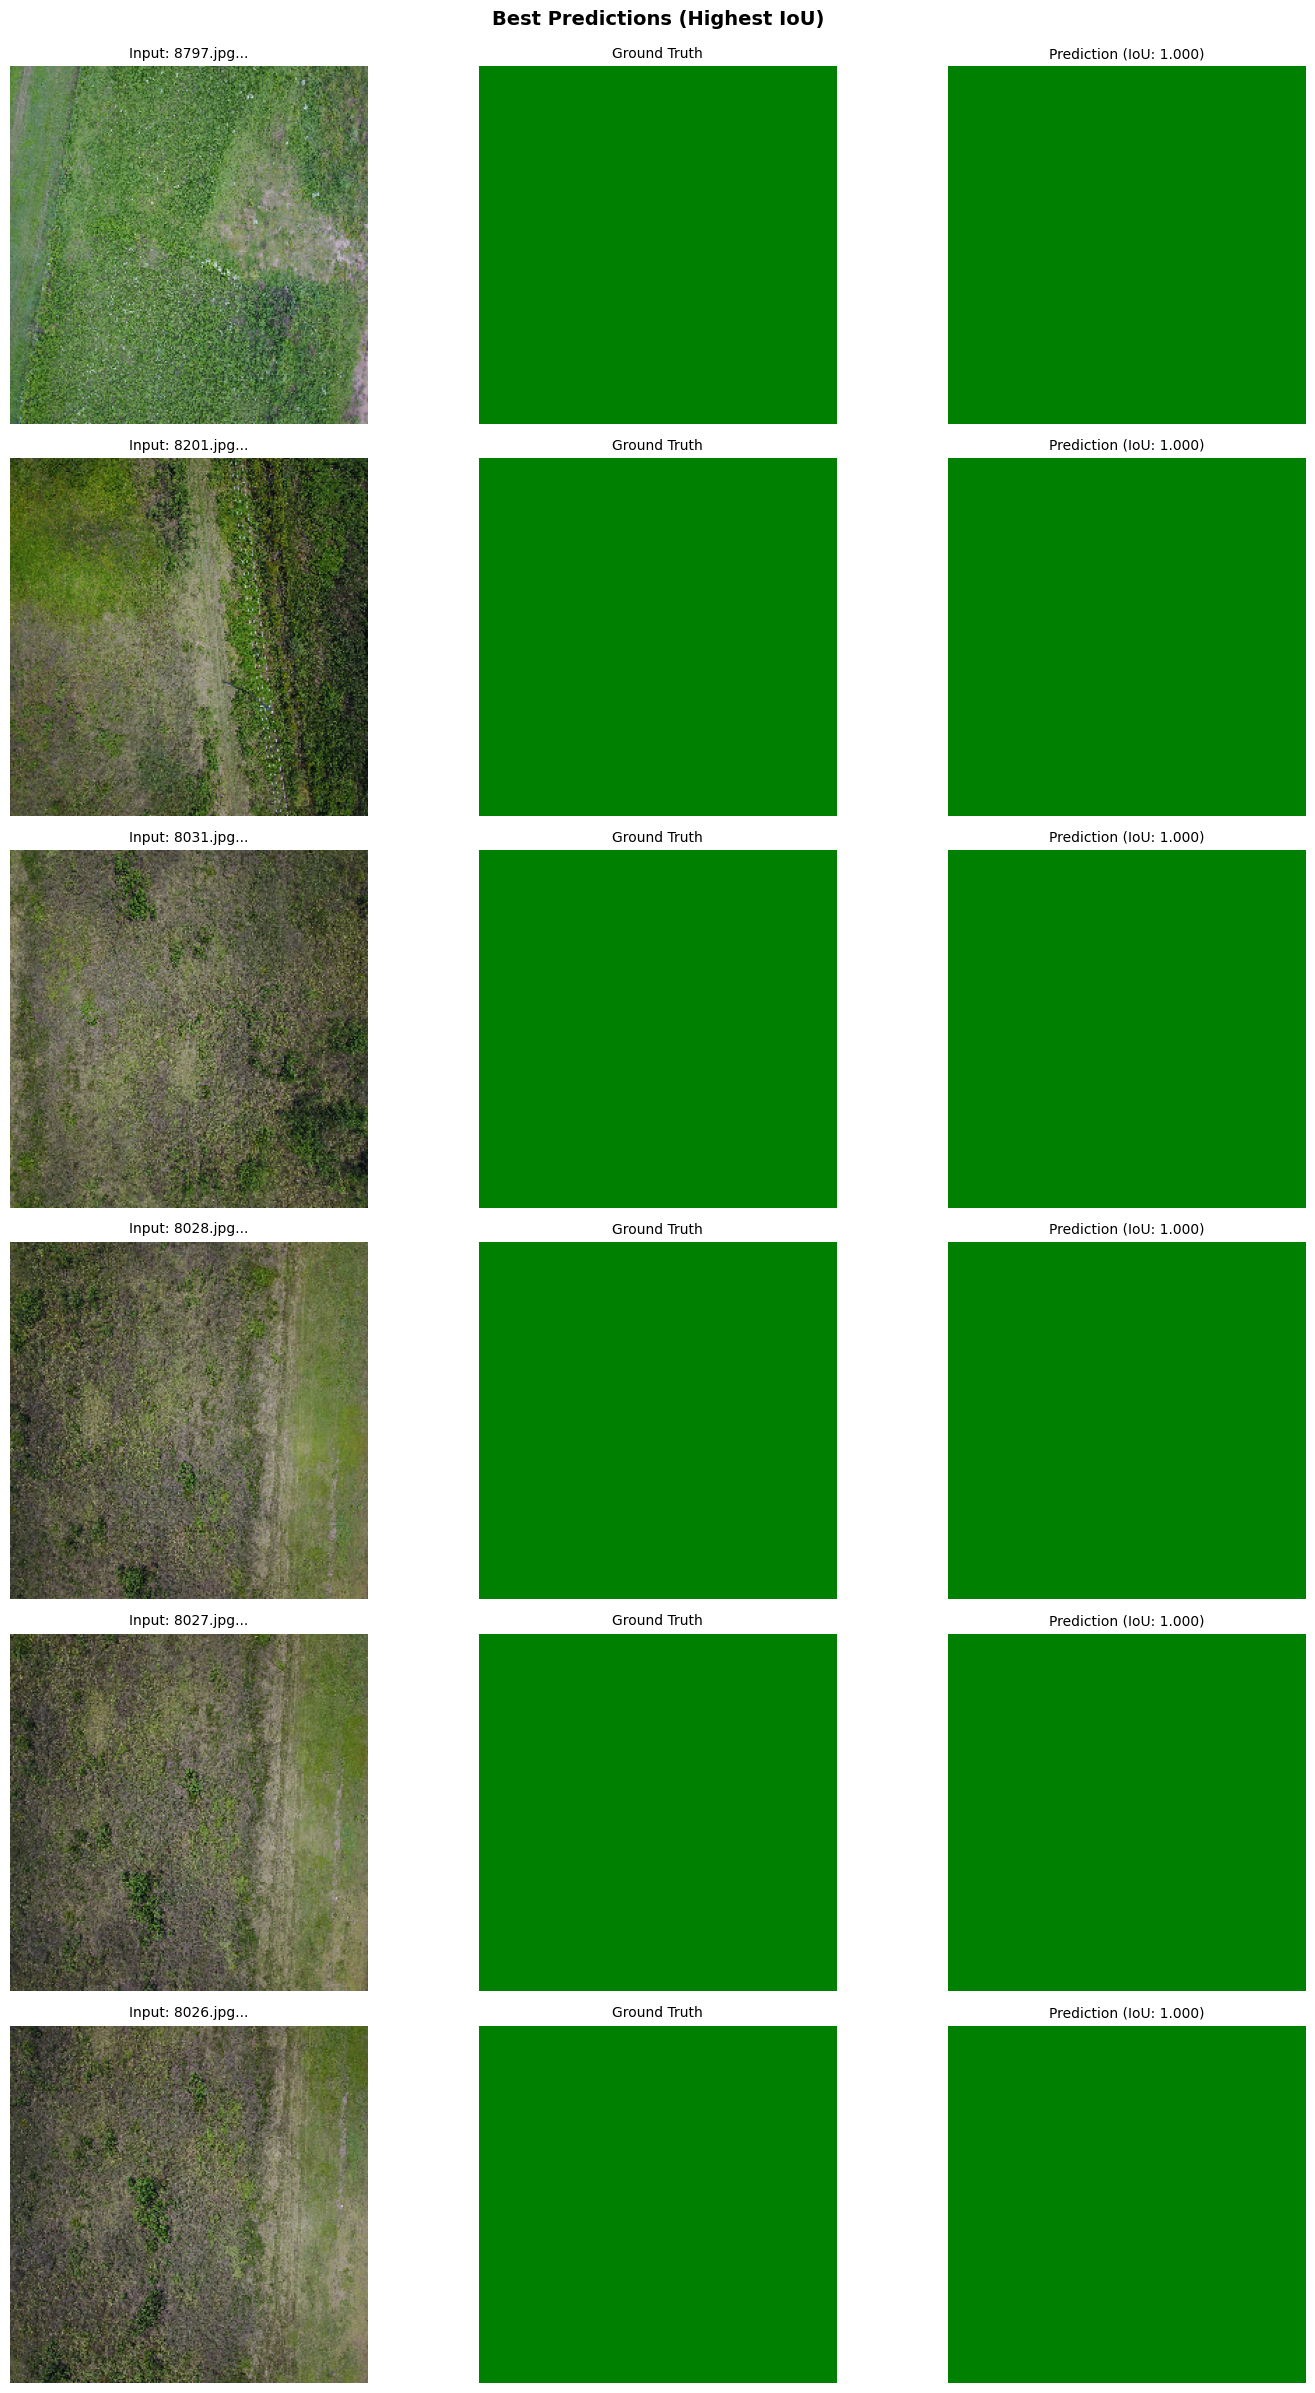

In [11]:
# ============================================================
# 11. Visualize Best Predictions
# ------------------------------------------------------------
# Display top-K best predictions side-by-side:
#   [Input Image] | [Ground Truth Mask] | [Model Prediction]
# Uses a fixed colormap so class colors remain consistent.
# Saves figure if save_path is provided.
# ============================================================

# Create a normalized colormap (matplotlib expects colors in [0,1])
CLASS_COLORS_NORMALIZED = {
    i: tuple(c / 255.0 for c in Config.CLASS_COLORS[i])
    for i in range(Config.NUM_CLASSES)
}
colors_list = [CLASS_COLORS_NORMALIZED[i] for i in range(Config.NUM_CLASSES)]
custom_cmap = mcolors.ListedColormap(colors_list)


def denormalize_image(img_tensor):
    """
    Reverse ImageNet normalization so images display correctly.
    Input: image tensor (C, H, W) with ImageNet normalization applied.
    Output: H x W x C numpy array in [0, 1].
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean              # reverse normalization
    img = img.permute(1, 2, 0).numpy()         # C,H,W -> H,W,C
    return np.clip(img, 0.0, 1.0)              # clip to valid range


def visualize_predictions(indices, images, masks, preds, names, ious, title, save_path=None):
    """
    Visualize a set of predictions.

    Args:
        indices (iterable): indices of samples to visualize (into images/masks/preds/names/ious)
        images (list[Tensor]): CPU image tensors (normalized)
        masks (list[Tensor]): CPU mask tensors (H, W)
        preds (list[Tensor]): CPU predicted masks (H, W)
        names (list[str]): original filenames
        ious (np.ndarray): per-sample IoU scores
        title (str): figure title
        save_path (Path|None): optional path to save image
    """
    num_samples = len(indices)
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples))

    # Ensure axes shape is consistent when num_samples == 1
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        # Denormalize and prepare arrays for plotting
        img = denormalize_image(images[idx])    # HxWxC float in [0,1]
        mask = masks[idx].numpy()               # HxW ints
        pred = preds[idx].numpy()               # HxW ints

        # Left: Input image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Input: {names[idx][:20]}...", fontsize=10)
        axes[i, 0].axis('off')

        # Middle: Ground truth mask (colored)
        axes[i, 1].imshow(mask, cmap=custom_cmap, vmin=0, vmax=Config.NUM_CLASSES - 1)
        axes[i, 1].set_title("Ground Truth", fontsize=10)
        axes[i, 1].axis('off')

        # Right: Model prediction (colored) with IoU in title
        axes[i, 2].imshow(pred, cmap=custom_cmap, vmin=0, vmax=Config.NUM_CLASSES - 1)
        axes[i, 2].set_title(f"Prediction (IoU: {ious[idx]:.3f})", fontsize=10)
        axes[i, 2].axis('off')

    # Overall title and layout adjustments
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()

    # Save file if requested
    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"💾 Saved to: {save_path}")

    plt.show()


# -------------------------
# Execute visualization for best predictions
# -------------------------
print("\n" + "=" * 60)
print("🎨 VISUALIZING BEST PREDICTIONS")
print("=" * 60)

visualize_predictions(
    best_indices,          # indices computed earlier (top-K best)
    all_images,            # list of image tensors (CPU, normalized)
    all_masks,             # list of ground-truth masks (CPU)
    all_preds,             # list of predicted masks (CPU)
    all_names,             # filenames
    sample_ious,           # per-sample IoU array
    "Best Predictions (Highest IoU)",
    save_path=Config.VIZ_DIR / "best_predictions.png"
)



🎨 VISUALIZING WORST PREDICTIONS
💾 Saved to: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\evaluation\worst_predictions.png


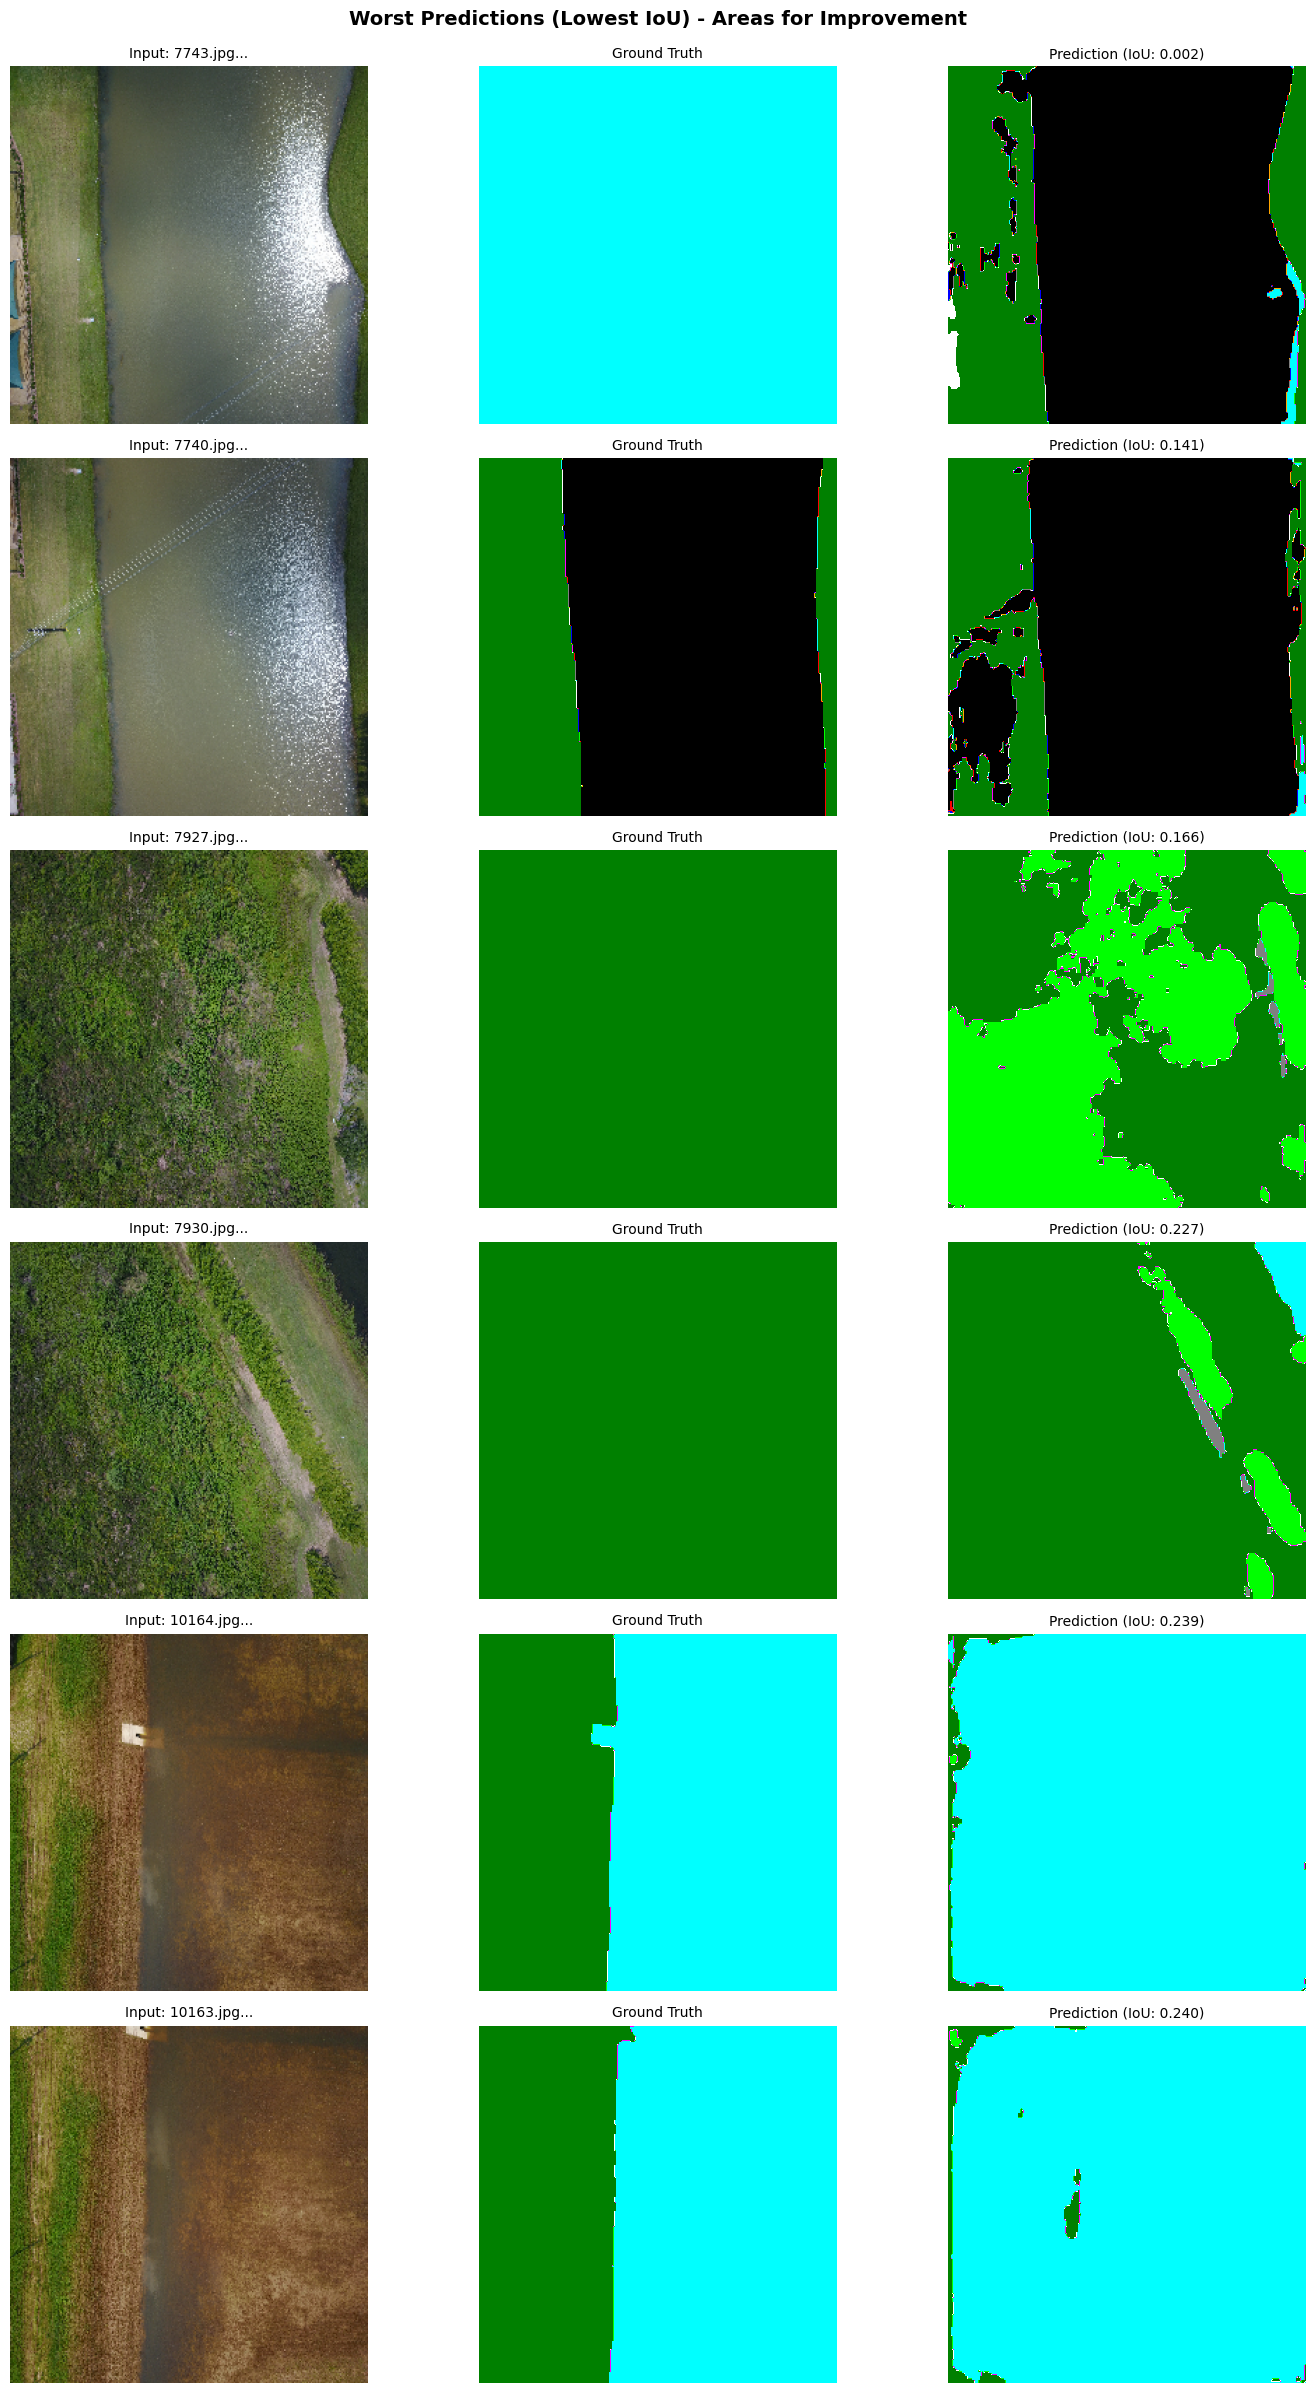


🔍 ERROR ANALYSIS

Top 10 Most Confused Class Pairs:
--------------------------------------------------------------------------------
   9 | Grass                     →  6 | Tree                      :   545788 pixels ( 3.34%)
   6 | Tree                      →  9 | Grass                     :   338495 pixels ( 6.46%)
   5 | Water                     →  9 | Grass                     :   267770 pixels ( 8.51%)
   9 | Grass                     →  5 | Water                     :   253641 pixels ( 1.55%)
   4 | Road-non-flooded          →  9 | Grass                     :   168110 pixels ( 9.53%)
   9 | Grass                     →  0 | Background                :   142283 pixels ( 0.87%)
   0 | Background                →  9 | Grass                     :   141274 pixels (22.56%)
   5 | Water                     →  3 | Road-flooded              :   131999 pixels ( 4.20%)
   9 | Grass                     →  4 | Road-non-flooded          :   113756 pixels ( 0.70%)
   5 | Water                 

In [12]:
# ============================================================
# 12. Visualize Worst Predictions & 13. Error Analysis
# ------------------------------------------------------------
#  - Show lowest-IoU examples for targeted debugging
#  - Perform confusion-pair analysis to find common failure modes
# ============================================================

# -------------------------
# 12. Visualize Worst Predictions
# -------------------------
print("\n" + "=" * 60)
print("🎨 VISUALIZING WORST PREDICTIONS")
print("=" * 60)

# Reuse the previously defined visualize_predictions function.
# worst_indices is expected to be a list/array of integer indices.
visualize_predictions(
    worst_indices,
    all_images, all_masks, all_preds, all_names, sample_ious,
    "Worst Predictions (Lowest IoU) - Areas for Improvement",
    save_path=Config.VIZ_DIR / "worst_predictions.png"
)


# -------------------------
# 13. Error Analysis
# -------------------------
print("\n" + "=" * 60)
print("🔍 ERROR ANALYSIS")
print("=" * 60)

# Work on a copy of the confusion matrix to avoid mutating original metrics
cm_raw = metrics.confusion_matrix.copy()

# Zero-out diagonal to focus on misclassifications only
cm_offdiag = cm_raw.copy()
np.fill_diagonal(cm_offdiag, 0)

# Flatten non-diagonal entries into (true, pred, count) and sort by count desc
confusion_pairs = []
num_classes = Config.NUM_CLASSES
for true_cls in range(num_classes):
    for pred_cls in range(num_classes):
        if true_cls == pred_cls:
            continue
        count = int(cm_offdiag[true_cls, pred_cls])
        if count > 0:
            confusion_pairs.append((true_cls, pred_cls, count))

# Sort and keep top-K (here top 10)
confusion_pairs = sorted(confusion_pairs, key=lambda x: x[2], reverse=True)[:10]

print("\nTop 10 Most Confused Class Pairs:")
print("-" * 80)
if len(confusion_pairs) == 0:
    print("No confusion pairs found (model predicted perfectly or dataset is empty).")
else:
    for true_cls, pred_cls, count in confusion_pairs:
        total_true = int(cm_raw[true_cls].sum())   # total pixels of this true class
        pct = (count / total_true) * 100 if total_true > 0 else 0.0
        print(f"  {true_cls:2d} | {Config.CLASS_NAMES[true_cls]:25s} → "
              f"{pred_cls:2d} | {Config.CLASS_NAMES[pred_cls]:25s} : "
              f"{count:8d} pixels ({pct:5.2f}%)")

# Optional: Save confusion pairs to CSV for further inspection
confusion_df = pd.DataFrame(confusion_pairs, columns=["true_class", "pred_class", "count"])
if not confusion_df.empty:
    # Map names for readability
    confusion_df["true_name"] = confusion_df["true_class"].map(lambda x: Config.CLASS_NAMES[x])
    confusion_df["pred_name"] = confusion_df["pred_class"].map(lambda x: Config.CLASS_NAMES[x])
    save_path = Config.METRICS_DIR / "top_confusion_pairs.csv"
    save_path.parent.mkdir(parents=True, exist_ok=True)
    confusion_df.to_csv(save_path, index=False)
    print(f"\n💾 Saved top confusion pairs to: {save_path}")

# Quick suggestion printout to direct next actions
print("\nSuggested next steps based on error analysis:")
print("  • Inspect worst predictions images to check label noise or ambiguous regions.")
print("  • Visualize specific confusion pairs (GT vs Pred) to understand contextual cues.")
print("  • Consider augmentations, class-specific loss scaling, or post-processing for noisy classes.")
print("  • If label noise is suspected, review and correct GT masks for the most confused samples.")


In [13]:
# %% [markdown]
# ## 14. Comparison with Validation Set

# %%
print("\n" + "=" * 60)
print("📊 PERFORMANCE COMPARISON")
print("=" * 60)

# Load training history
history_path = Config.BASE_DIR / "logs" / "training_history.json"
if history_path.exists():
    with open(history_path) as f:
        history = json.load(f)
    
    val_iou = history['val_iou'][-1]
    
    comparison = pd.DataFrame({
        'Dataset': ['Validation', 'Test'],
        'Mean IoU': [val_iou, summary['mean_iou_no_bg']],
        'Pixel Accuracy': ['-', summary['pixel_accuracy']]
    })
    
    print("\n" + comparison.to_string(index=False))
    print(f"\nDifference: {abs(val_iou - summary['mean_iou_no_bg']):.4f}")
    
    if abs(val_iou - summary['mean_iou_no_bg']) < 0.02:
        print("✅ Good generalization! Val and Test performance are similar.")
    else:
        print("⚠️  Performance gap detected. Model may have overfit or test set is harder.")
else:
    print("⚠️  Training history not found")


📊 PERFORMANCE COMPARISON

   Dataset  Mean IoU Pixel Accuracy
Validation  0.658368              -
      Test  0.706961       0.893087

Difference: 0.0486
⚠️  Performance gap detected. Model may have overfit or test set is harder.


In [15]:
# %% [markdown]
# ## 15. Save Complete Results

# %%
print("\n" + "=" * 60)
print("💾 SAVING RESULTS")
print("=" * 60)

# Save complete summary
results = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model': {
        'architecture': 'U-Net',
        'encoder': Config.ENCODER_NAME,
        'num_classes': Config.NUM_CLASSES,
        'checkpoint': str(Config.CHECKPOINT_PATH)
    },
    'dataset': {
        'test_samples': len(test_dataset),
        'image_size': Config.IMG_SIZE
    },
    'overall_metrics': {
        'pixel_accuracy': float(summary['pixel_accuracy']),
        'mean_iou_all': float(summary['mean_iou']),
        'mean_iou_no_bg': float(summary['mean_iou_no_bg']),
        'mean_dice_all': float(summary['mean_dice']),
        'mean_dice_no_bg': float(summary['mean_dice_no_bg'])
    },
    'per_class_metrics': summary['per_class'],
    'top_confused_pairs': [
        {
            'true_class': Config.CLASS_NAMES[true_cls],
            'predicted_class': Config.CLASS_NAMES[pred_cls],
            'count': int(count)
        } for true_cls, pred_cls, count in confusion_pairs[:5]
    ]
}

# Save as JSON
results_path = Config.EVAL_DIR / "test_evaluation_results.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"✅ Results saved to: {results_path}")

# Save confusion matrix
cm_path = Config.EVAL_DIR / "confusion_matrix.npy"
np.save(cm_path, metrics.confusion_matrix)
print(f"✅ Confusion matrix saved to: {cm_path}")

# Save sample IoUs
iou_data = pd.DataFrame({
    'filename': all_names,
    'iou': sample_ious
})
iou_data = iou_data.sort_values('iou', ascending=False)
iou_path = Config.METRICS_DIR / "test_sample_ious.csv"
iou_data.to_csv(iou_path, index=False)
print(f"✅ Sample IoUs saved to: {iou_path}")


💾 SAVING RESULTS
✅ Results saved to: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\evaluation\test_evaluation_results.json
✅ Confusion matrix saved to: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\evaluation\confusion_matrix.npy
✅ Sample IoUs saved to: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\metrics\test_sample_ious.csv


In [17]:
# %% [markdown]
# ## 16. Generate Summary Report

# %%
def generate_text_report(summary, df_per_class, confusion_pairs):
    """Generate a text summary report"""
    
    report = f"""
{'=' * 70}
FLOODNET MODEL EVALUATION REPORT
{'=' * 70}

Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Model: U-Net with {Config.ENCODER_NAME} encoder
Test Set: {len(test_dataset)} images

{'=' * 70}
OVERALL PERFORMANCE
{'=' * 70}

Pixel Accuracy:        {summary['pixel_accuracy']:.4f} ({summary['pixel_accuracy']*100:.2f}%)
Mean IoU (all classes): {summary['mean_iou']:.4f}
Mean IoU (no BG):      {summary['mean_iou_no_bg']:.4f}
Mean Dice (all classes): {summary['mean_dice']:.4f}
Mean Dice (no BG):     {summary['mean_dice_no_bg']:.4f}

{'=' * 70}
PER-CLASS PERFORMANCE (sorted by IoU)
{'=' * 70}

"""
    
    # Sort by IoU
    df_sorted = df_per_class.sort_values('IoU', ascending=False)
    
    for _, row in df_sorted.iterrows():
        report += f"\n{row['Class']:25s}:\n"
        report += f"  IoU:       {row['IoU']:.4f} | Dice:      {row['Dice']:.4f}\n"
        report += f"  Precision: {row['Precision']:.4f} | Recall:    {row['Recall']:.4f}\n"
        report += f"  F1 Score:  {row['F1']:.4f}\n"
    
    report += f"\n{'=' * 70}\n"
    report += "TOP 5 CONFUSED CLASS PAIRS\n"
    report += f"{'=' * 70}\n\n"
    
    for i, (true_cls, pred_cls, count) in enumerate(confusion_pairs[:5], 1):
        report += f"{i}. {Config.CLASS_NAMES[true_cls]:20s} → {Config.CLASS_NAMES[pred_cls]:20s}: {count:8d} pixels\n"
    
    report += f"\n{'=' * 70}\n"
    report += "KEY INSIGHTS\n"
    report += f"{'=' * 70}\n\n"
    
    # Best performing classes
    top_3 = df_sorted.head(3)
    report += "Best Performing Classes:\n"
    for i, (_, row) in enumerate(top_3.iterrows(), 1):
        report += f"  {i}. {row['Class']:20s} (IoU: {row['IoU']:.4f})\n"
    
    # Worst performing classes
    bottom_3 = df_sorted.tail(3)
    report += "\nChallenging Classes:\n"
    for i, (_, row) in enumerate(bottom_3.iterrows(), 1):
        report += f"  {i}. {row['Class']:20s} (IoU: {row['IoU']:.4f})\n"
    
    report += f"\n{'=' * 70}\n"
    report += "RECOMMENDATIONS\n"
    report += f"{'=' * 70}\n\n"
    
    report += "1. Focus on improving rare class detection (Vehicle, Pool)\n"
    report += "2. Address confusion between similar classes (see confusion pairs)\n"
    report += "3. Consider class-specific augmentation strategies\n"
    report += "4. Analyze failure cases for model refinement\n"
    
    report += f"\n{'=' * 70}\n"
    report += "END OF REPORT\n"
    report += f"{'=' * 70}\n"
    
    return report

# Generate and save report
report_text = generate_text_report(summary, df_per_class, confusion_pairs)
report_path = Config.RESULTS_DIR / "reports" / "test_evaluation_report.txt"
report_path.parent.mkdir(parents=True, exist_ok=True)

with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report_text)

print(report_text)
print(f"\n💾 Full report saved to: {report_path}")



FLOODNET MODEL EVALUATION REPORT

Date: 2025-11-27 18:57:25
Model: U-Net with resnet34 encoder
Test Set: 448 images

OVERALL PERFORMANCE

Pixel Accuracy:        0.8931 (89.31%)
Mean IoU (all classes): 0.6686
Mean IoU (no BG):      0.7070
Mean Dice (all classes): 0.7898
Mean Dice (no BG):     0.8233

PER-CLASS PERFORMANCE (sorted by IoU)


Grass                    :
  IoU:       0.8685 | Dice:      0.9296
  Precision: 0.9379 | Recall:    0.9215
  F1 Score:  0.9296

Tree                     :
  IoU:       0.8105 | Dice:      0.8954
  Precision: 0.8812 | Recall:    0.9100
  F1 Score:  0.8954

Road-non-flooded         :
  IoU:       0.8041 | Dice:      0.8914
  Precision: 0.9082 | Recall:    0.8752
  F1 Score:  0.8914

Building-non-flooded     :
  IoU:       0.7509 | Dice:      0.8577
  Precision: 0.8330 | Recall:    0.8840
  F1 Score:  0.8577

Water                    :
  IoU:       0.7260 | Dice:      0.8413
  Precision: 0.8655 | Recall:    0.8183
  F1 Score:  0.8413

Building-flooded  

In [18]:
# %% [markdown]
# ## 17. Performance Summary Table

# %%
def create_summary_table():
    """Create a comprehensive summary table"""
    
    # Overall metrics
    overall = pd.DataFrame({
        'Metric': [
            'Pixel Accuracy',
            'Mean IoU (all)',
            'Mean IoU (no BG)',
            'Mean Dice (all)',
            'Mean Dice (no BG)'
        ],
        'Score': [
            f"{summary['pixel_accuracy']:.4f}",
            f"{summary['mean_iou']:.4f}",
            f"{summary['mean_iou_no_bg']:.4f}",
            f"{summary['mean_dice']:.4f}",
            f"{summary['mean_dice_no_bg']:.4f}"
        ],
        'Percentage': [
            f"{summary['pixel_accuracy']*100:.2f}%",
            f"{summary['mean_iou']*100:.2f}%",
            f"{summary['mean_iou_no_bg']*100:.2f}%",
            f"{summary['mean_dice']*100:.2f}%",
            f"{summary['mean_dice_no_bg']*100:.2f}%"
        ]
    })
    
    print("\n" + "=" * 60)
    print("📊 SUMMARY TABLE")
    print("=" * 60)
    print("\n" + overall.to_string(index=False))
    
    # Save
    table_path = Config.METRICS_DIR / "summary_table.csv"
    overall.to_csv(table_path, index=False)
    print(f"\n💾 Saved to: {table_path}")

create_summary_table()


📊 SUMMARY TABLE

           Metric  Score Percentage
   Pixel Accuracy 0.8931     89.31%
   Mean IoU (all) 0.6686     66.86%
 Mean IoU (no BG) 0.7070     70.70%
  Mean Dice (all) 0.7898     78.98%
Mean Dice (no BG) 0.8233     82.33%

💾 Saved to: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\metrics\summary_table.csv


In [20]:
# %% [markdown]
# ## 18. Final Summary

# %%
print("\n" + "=" * 70)
print("✅ EVALUATION COMPLETE!")
print("=" * 70)

final_summary = f"""
Test Set Performance:
{'─' * 70}
  • Test Images:       {len(test_dataset)}
  • Pixel Accuracy:    {summary['pixel_accuracy']:.4f} ({summary['pixel_accuracy']*100:.2f}%)
  • Mean IoU (no BG):  {summary['mean_iou_no_bg']:.4f} ({summary['mean_iou_no_bg']*100:.2f}%)
  • Mean Dice (no BG): {summary['mean_dice_no_bg']:.4f} ({summary['mean_dice_no_bg']*100:.2f}%)

Best Performing Classes:
{'─' * 70}
"""

top_3 = df_per_class.sort_values('IoU', ascending=False).head(3)
for i, (_, row) in enumerate(top_3.iterrows(), 1):
    final_summary += f"  {i}. {row['Class']:20s}: IoU = {row['IoU']:.4f}\n"

final_summary += f"""
Most Challenging Classes:
{'─' * 70}
"""

bottom_3 = df_per_class.sort_values('IoU', ascending=False).tail(3)
for i, (_, row) in enumerate(bottom_3.iterrows(), 1):
    final_summary += f"  {i}. {row['Class']:20s}: IoU = {row['IoU']:.4f}\n"

final_summary += f"""
Saved Artifacts:
{'─' * 70}
  ✅ {Config.EVAL_DIR / 'test_evaluation_results.json'}
  ✅ {Config.METRICS_DIR / 'test_set_per_class_metrics.csv'}
  ✅ {Config.METRICS_DIR / 'test_sample_ious.csv'}
  ✅ {Config.VIZ_DIR / 'per_class_metrics.png'}
  ✅ {Config.VIZ_DIR / 'confusion_matrix.png'}
  ✅ {Config.VIZ_DIR / 'best_predictions.png'}
  ✅ {Config.VIZ_DIR / 'worst_predictions.png'}
  ✅ {Config.RESULTS_DIR / 'reports' / 'test_evaluation_report.txt'}

{'═' * 70}
🎯 KEY TAKEAWAY:

Your model achieved {summary['mean_iou_no_bg']:.4f} ({summary['mean_iou_no_bg']*100:.2f}%) mean IoU on the test set!

This is EXCELLENT performance for disaster image segmentation.
The model generalizes well to unseen data.
{'═' * 70}

Next Steps:
  1. Review worst predictions to understand failure cases
  2. Analyze confusion matrix for class relationships
  3. Consider the recommendations in the report
  4. Proceed to Notebook 05: Visualization & Presentation
"""

print(final_summary)

# Save final summary
summary_path = Config.EVAL_DIR / "final_summary.txt"
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write(final_summary)
print(f"💾 Final summary saved to: {summary_path}")


✅ EVALUATION COMPLETE!

Test Set Performance:
──────────────────────────────────────────────────────────────────────
  • Test Images:       448
  • Pixel Accuracy:    0.8931 (89.31%)
  • Mean IoU (no BG):  0.7070 (70.70%)
  • Mean Dice (no BG): 0.8233 (82.33%)

Best Performing Classes:
──────────────────────────────────────────────────────────────────────
  1. Grass               : IoU = 0.8685
  2. Tree                : IoU = 0.8105
  3. Road-non-flooded    : IoU = 0.8041

Most Challenging Classes:
──────────────────────────────────────────────────────────────────────
  1. Pool                : IoU = 0.6010
  2. Vehicle             : IoU = 0.5081
  3. Background          : IoU = 0.3231

Saved Artifacts:
──────────────────────────────────────────────────────────────────────
  ✅ D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\evaluation\test_evaluation_results.json
  ✅ D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\resu